# Cirrhosis Prediction Dataset


## Project Overview
 The Cirrhosis Prediction Dataset presents an exciting opportunity to comprehend and analyze the intricacies of this complex condition using data-driven approaches. This project entails utilizing the Cirrhosis Prediction Dataset to develop a predictive model aimed at providing accurate forecasts regarding cases of liver cirrhosis in patients.
   * What is the target?
       - Status

## Load and Inspect Data

In [627]:
# Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score , recall_score , f1_score  , confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score, RocCurveDisplay

In [628]:
# EDA 

def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



In [629]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [630]:
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
  """Converts float value probabilities into int value predictions.
  If the probability of class 1 is greater than the threshold, the prediction is 1
  Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
  predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
  return predictions

In [631]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax


### Explore/clean the data

In [632]:
df=pd.read_csv('cirrhosis.csv')
df=df.drop(columns="ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [633]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


* How many features does the data have?
   - 19 columns
* How many rows are in the dataset?
    - 418 row 

In [634]:
# null value  
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [635]:
df['Status'].replace({'CL':'C'},inplace=True)

In [636]:
#convert target : status of the patient C (censored)or D (death)
df['Status'].replace({'C':0,'D':1},inplace=True)

<Axes: >

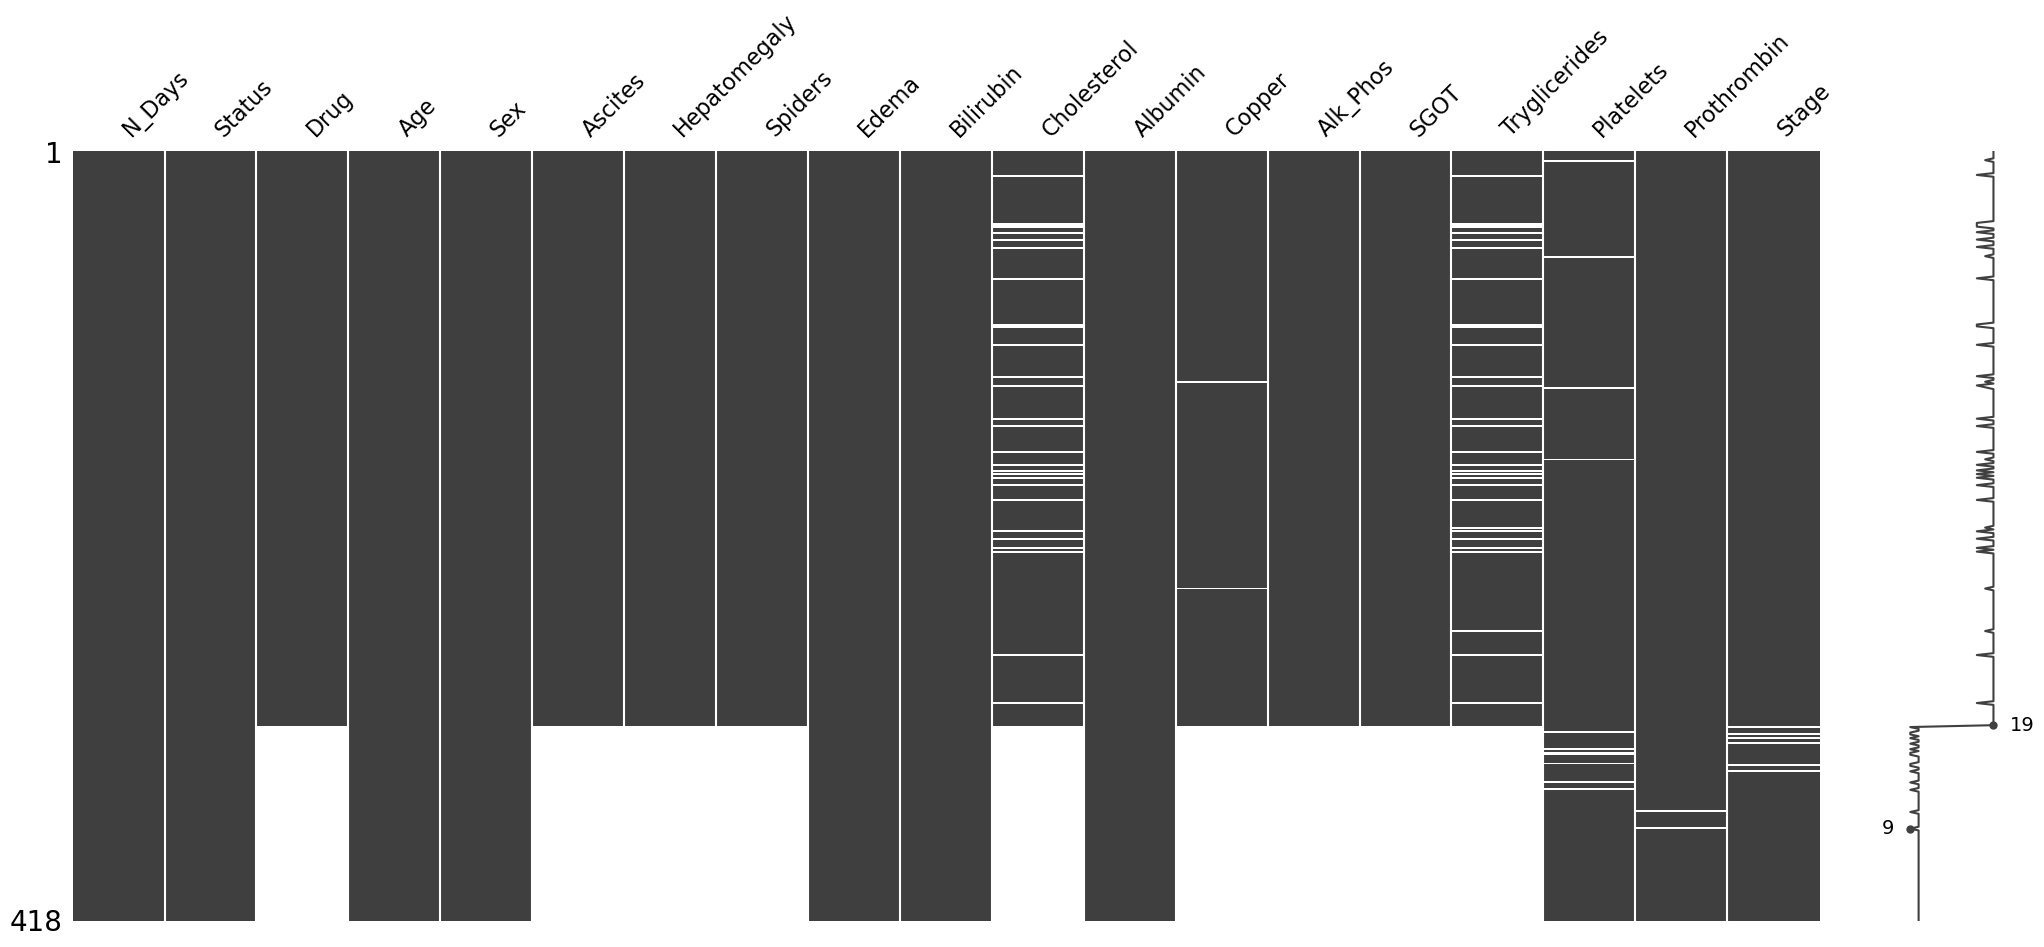

In [637]:
# Visualize missing values as a matrix 
import missingno as msno
msno.matrix(df)

In [638]:
#  duplicated 
df.duplicated().sum()

0

In [639]:
df.describe()

,N_Days,Status,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,0.385167,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,0.487218,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,0.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,0.000000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,0.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,1.000000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,1.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


In [640]:
# convert a column representing days into a column representing years.
df['Age[y]']=df['Age']/365
df=df.drop(columns='Age')


In [641]:
# convert target 
#df['Status'].replace({'C': 0, 'CL': 1, 'D': 2}, inplace=True)


In [642]:
df['Status'].value_counts(dropna=False)

0    257
1    161
Name: Status, dtype: int64

In [643]:
# describion object columns
df.describe(include="object")

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,312,418,312,312,312,418
unique,2,2,2,2,2,3
top,D-penicillamine,F,N,Y,N,N
freq,158,374,288,160,222,354


## Exploratory Data Analysis

<Axes: >

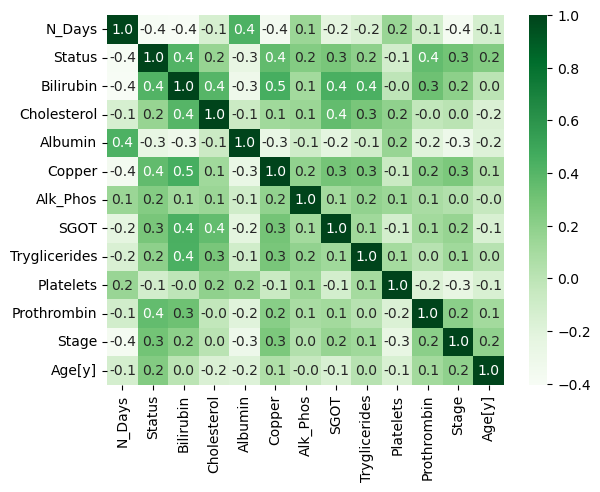

In [644]:
corr=df.corr(numeric_only=True)
sns.heatmap(corr,annot=True,fmt='.1f', cbar="k", cmap="Greens")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Sex vs. Status'}, xlabel='Sex', ylabel='Percent'>)

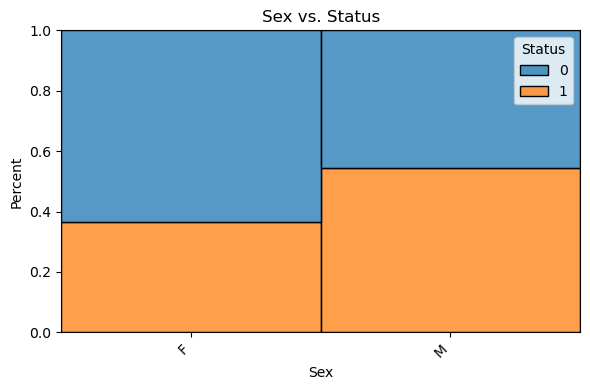

In [645]:
plot_categorical_vs_target(df,x='Sex',y='Status',target_type="class")

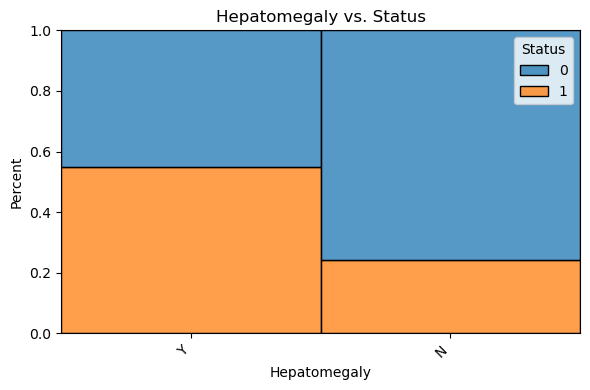

In [646]:
plot_categorical_vs_target(df,x='Hepatomegaly',y='Status',target_type="class",fillna=False)
plt.savefig('Hepatomegaly')

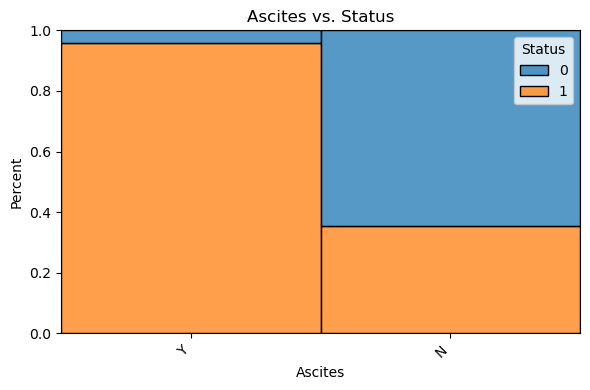

In [647]:
plot_categorical_vs_target(df,x='Ascites',y='Status',target_type="class",fillna=False)
plt.savefig('Ascites')

* The presence of ascites in cirrhosis can be an indicator of the health condition and thus its risk. Ascites is the clarification of the abdominal cavities (salts), and often occurs as a result of portal hypertension, which occurs due to liver dysfunction such as cirrhosis.
* As for liver enlargement, it is an increase in the size of the liver, and may be the result of the accumulation of fat in the liver (fatty liver), water retention (ascites), or the growth of tumors.
* The presence of ascites and enlarged liver can be important signs of cirrhosis


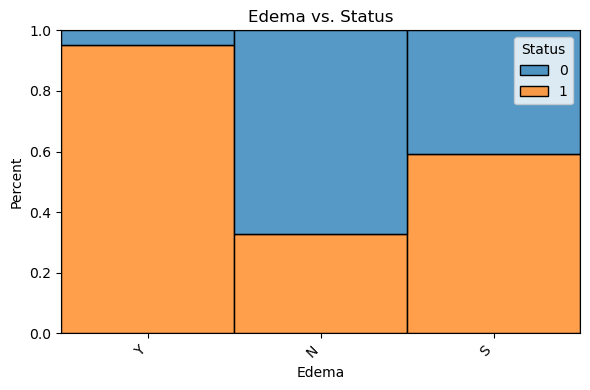

In [648]:
plot_categorical_vs_target(df,x='Edema',y='Status',target_type="class")
plt.savefig('my_plot.png')

* Edema is a condition characterized by the accumulation of fluid in the external tissues of the body, and may appear in the extremities such as the legs and feet, and in the lower parts of the abdomen. Edema is common in people with cirrhosis and is one of the main signs of liver failure


- Excluding 106 NaN's


C:\Users\Ashraf\AppData\Local\Temp\ipykernel_14728\247250267.py:98: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


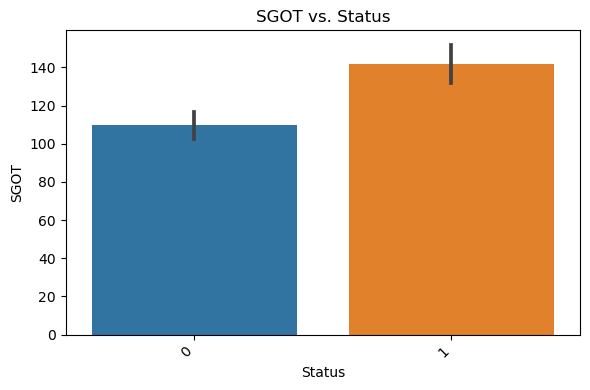

In [649]:
# Add sorting the target's categories
plot_numeric_vs_target(df,'SGOT','Status', target_type='class', sorted=False, ascending=True);




* High levels of the enzyme AST (SGOT) may occur in cases of liver cirrhosis. Leakage of enzymes from the liver into the blood as a result of damage to liver cells

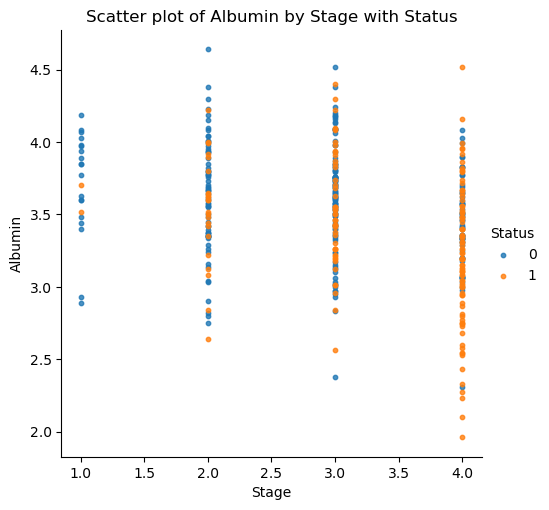

In [650]:
g=sns.lmplot(data=df,x='Stage',y='Albumin',hue="Status",fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.8, 'linewidth': 1, } )
plt.title('Scatter plot of Albumin by Stage with Status')
# Display the plot
plt.show()
g.savefig('Albumin')

* Low blood albumin can be an indicator of cirrhosis and may be linked to an increased risk of death for people with liver problems.

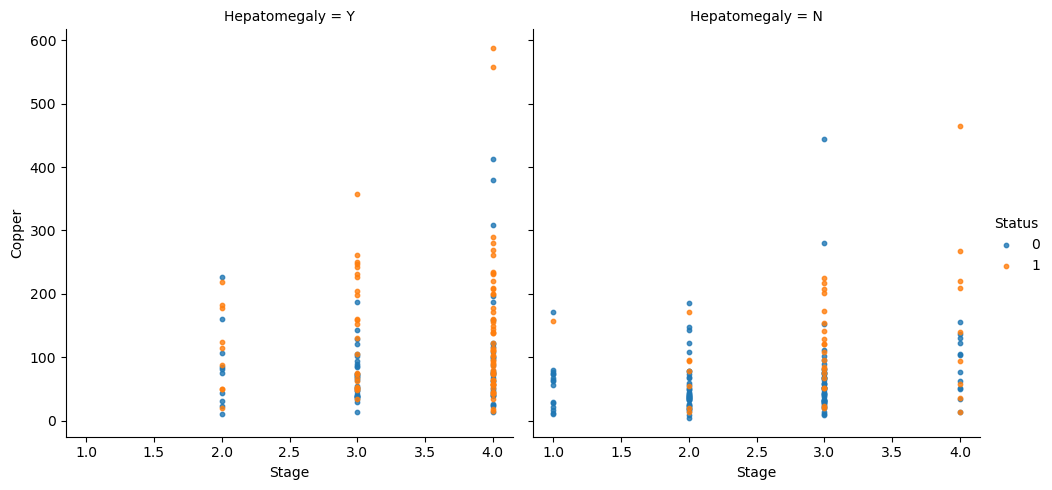

In [651]:
# Plotting the lmplot
grid = sns.lmplot(data=df, x='Stage', y='Copper', hue="Status", fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.8, 'linewidth': 1}, col="Hepatomegaly", )
plt.show()
grid .savefig('Copper')


- Increased levels of copper in the urine may be evidence of liver cirrhosis. The liver plays a role in copper metabolism, and when there is liver damage, it may increase the excretion of copper in the urine.

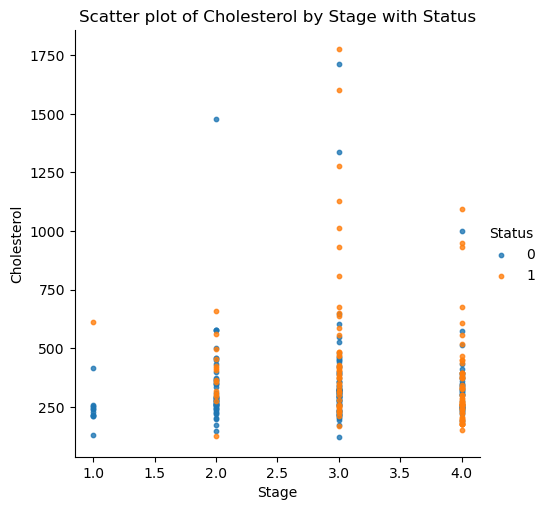

In [652]:
grid = sns.lmplot(data=df, x='Stage', y='Cholesterol', hue="Status", fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.8, 'linewidth': 1} )
plt.title('Scatter plot of Cholesterol by Stage with Status')
plt.show()

* Cholesterol levels play an important role in overall health and may be related to liver cirrhosis, but the relationship between them may be complex and depend on multiple factors.

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Spiders vs. Status'}, xlabel='Spiders', ylabel='Percent'>)

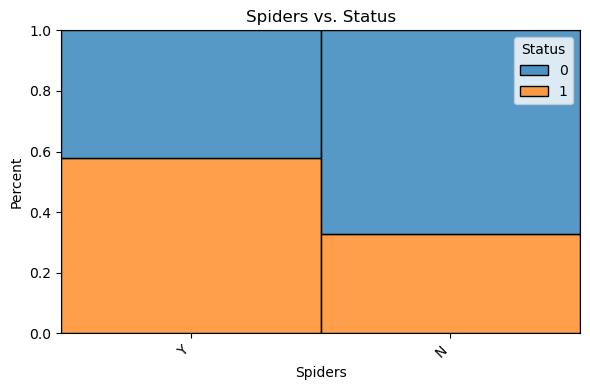

In [653]:
plot_categorical_vs_target(df,x='Spiders',y='Status',target_type="class",fillna=False)

* Signs of "spiders" in the skin indicate high blood pressure outside, a common indicator of cirrhosis.

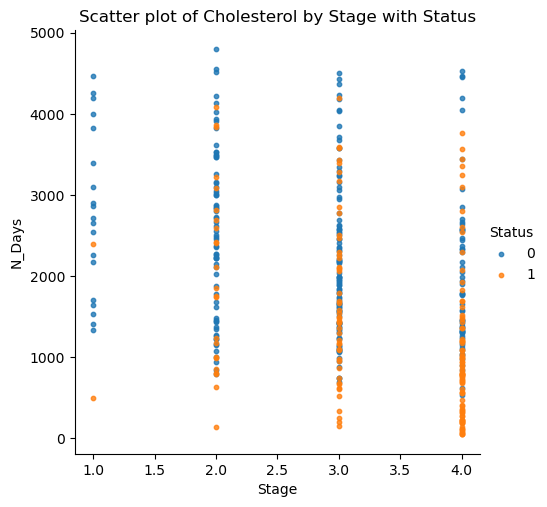

In [681]:
grid = sns.lmplot(data=df, x='Stage', y='N_Days', hue="Status", fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.8, 'linewidth': 1} )
plt.title('Scatter plot of Cholesterol by Stage with Status')
plt.show()

# Preprocesing for Machine Learning

* Identify the target (X) and features (y): We will assign the 'salary_in_usd' as the target and the rest of the relevant variables as the features matrix.
* Perform a train test split 
* Create a pre processing pipeline to prepare the dataset for Machine Learning

In [654]:
## Define X and y
y = df['Status']
X=df.drop(columns="Status")

In [655]:
df1.isna().sum()

N_Days             0
Status             0
Drug             106
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Age[y]             0
dtype: int64

In [656]:
# Perfoming a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Making a Preprocessing Pipeline 

<Axes: >

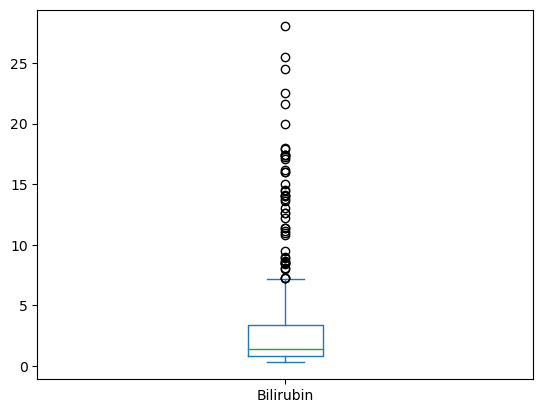

In [657]:
df['Bilirubin'].plot(kind="box")
# outlyare data 

 * Choosing the median as a proxy for missing data can be useful in many cases, especially when the data distribution is nonstandard or contains outlying standardized values. In the example of bilirubin in patients with cirrhosis, there may be missing or implausible values due to changes in liver function

In [658]:
#  Create the preprocessing pipeline for numeric data
numeric_columns=X_train.select_dtypes("number").columns
# Scaler
scaler=StandardScaler()
#imputer
imputer=SimpleImputer(strategy="median")
# Instantiate the pipeline
numeric_pipe= make_pipeline(imputer,scaler)
# Make the tuple for ColumnTransformer
numeric_tuple= ("numarical",numeric_pipe ,numeric_columns )
print(numeric_tuple)

('numarical', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object'))


In [659]:
# Create the preprocessing pipeline for categorical  data
categorical_columns =X_train.select_dtypes("object").columns
imputer_categorical = SimpleImputer(strategy="constant",fill_value="NA")
#OneHotEncoder
oht_categorical = OneHotEncoder(drop="if_binary", sparse_output=False )
# Instantiate the pipeline
categorical_pipeline= make_pipeline(imputer_categorical,oht_categorical)
# Make the tuple for ColumnTransformer
categorical_tuple= ("categorical" , categorical_pipeline , categorical_columns)


In [660]:
# Create the preprocessing ColumnTransformer
preprocessing_Column= ColumnTransformer([numeric_tuple,categorical_tuple],  remainder="drop", verbose_feature_names_out=False)
preprocessing_Column

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

## Machine Learning models

### A) RandomForestClassifier

In [661]:
# Instantiate default random forest model
rf =RandomForestClassifier(random_state = 42,class_weight="balanced")
# Model Pipeline
rf_pipe = make_pipeline(preprocessing_Column, rf)
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numarical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object')),
                                                 ('categ...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00       117

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313



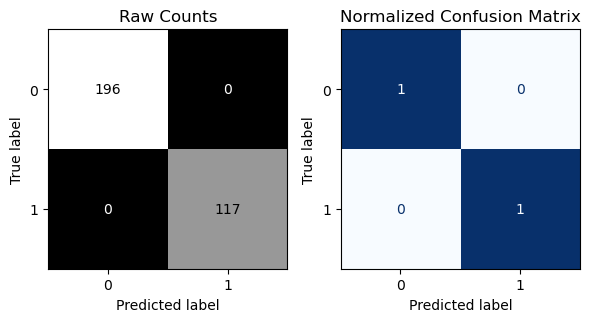


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        61
           1       0.89      0.75      0.81        44

    accuracy                           0.86       105
   macro avg       0.87      0.84      0.85       105
weighted avg       0.86      0.86      0.85       105



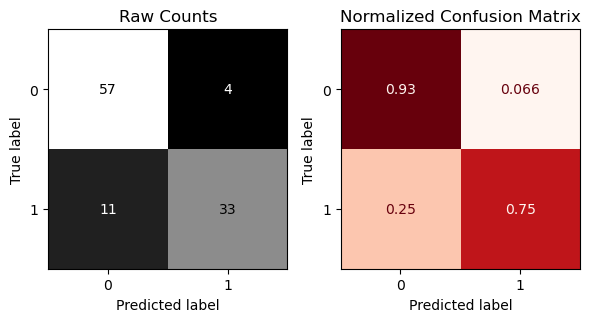

In [662]:
# Use custom function to evalute the model
evaluate_classification(rf_pipe,X_train,y_train, X_test, y_test)

* Model implementation:
   - precision: about 0.79% for the C class and  0.91% for the D class  .
   - Recall: about 0.95% for the C class and  0.66for the D class  .
   - F1 score: about 0.87% for the C class and 0.76 for the D class  .
 
 
 
 * It shows that the model performs well in Class C and D classification, but there is merit to improve its performance in Class CL classification

### B) RandomForestClassifier tuning

In [663]:
#randomforestclassifier tuning
# View parameters that could be tuned
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numarical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
          'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='NA',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
         

In [664]:
param= {'randomforestclassifier__min_samples_split': list(range(2,8,2)),
        'randomforestclassifier__n_estimators': [100,150,200,300],
        'randomforestclassifier__max_depth':[ 2, 3, 4, 5, 6, 7, 8, 9, 10, None]}


In [665]:
#Instantiate GridSearchCV
gs_rfc= GridSearchCV(rf_pipe,param, n_jobs=-1, verbose=1 , cv=5 )
# Fit the Gridsearch on the training data
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numarical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y...
                                                                         Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7,
                                                               8, 9, 10, None],
                         'randomforestclassifier__min_samples_split': [2, 4, 6],
                         'randomforestclassifier__n_estimators': [100, 150, 200,
                                                                  300]},
             verbose=1)

In [666]:
# get best param
gs_rfc.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

In [667]:
#best_estimator
gs_best=gs_rfc.best_estimator_

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       196
           1       0.86      0.82      0.84       117

    accuracy                           0.88       313
   macro avg       0.88      0.87      0.88       313
weighted avg       0.88      0.88      0.88       313



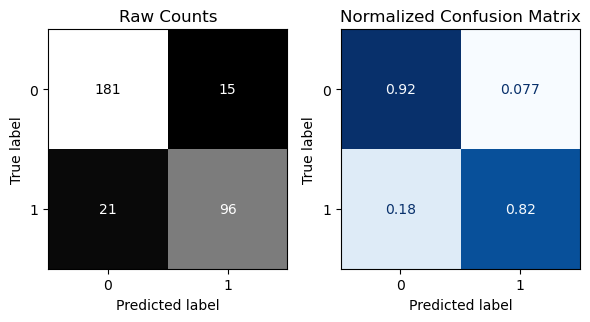


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        61
           1       0.78      0.73      0.75        44

    accuracy                           0.80       105
   macro avg       0.80      0.79      0.79       105
weighted avg       0.80      0.80      0.80       105



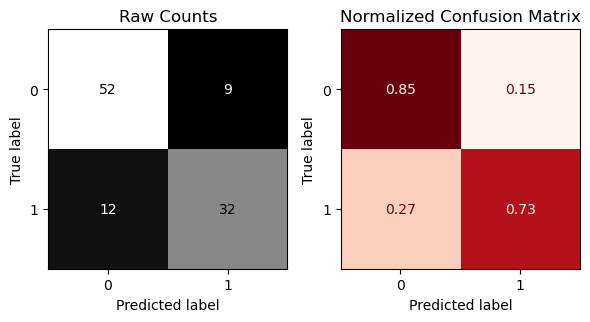

In [668]:
# Use custom function to evalute the model
evaluate_classification(gs_rfc.best_estimator_ ,X_train,y_train, X_test, y_test)

Precision: The accuracy for classes C and D seems good, ranging between 0.81 and 0.82, respectively. This means that most samples classified as C or D are the correct categories.
Recall: Recall also seems to be good, ranging between 0.70 and 0.89 for Classes C and D respectively. This means that the model distinguishes and classifies samples well from each category.
Square ratio (F1-score): The mean value of the square ratio shows a significant improvement, ranging between 0.76 and 0.84 for classes C and D, respectively.
Overall Accuracy: The model accuracy shows improvement and is around 0.81, meaning that 81% of the samples are classified correctly.

In [669]:
# Decision Thresholds
test_probs=gs_best.predict_proba(X_test)
test_probs[0:5]

array([[0.7003584 , 0.2996416 ],
       [0.60748951, 0.39251049],
       [0.66800548, 0.33199452],
       [0.3133374 , 0.6866626 ],
       [0.16328443, 0.83671557]])

C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


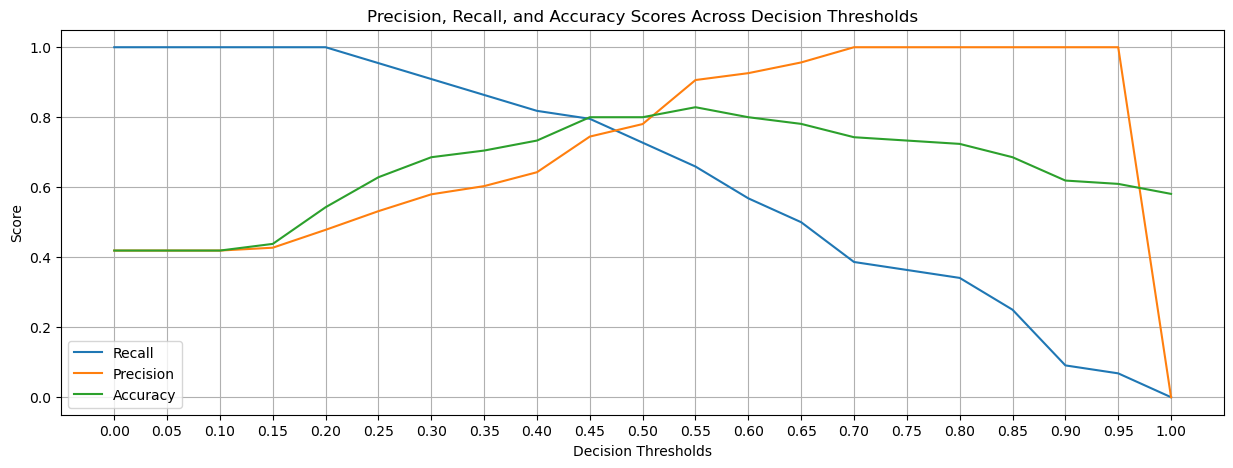

In [670]:
# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)
# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []
# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(test_probs, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()


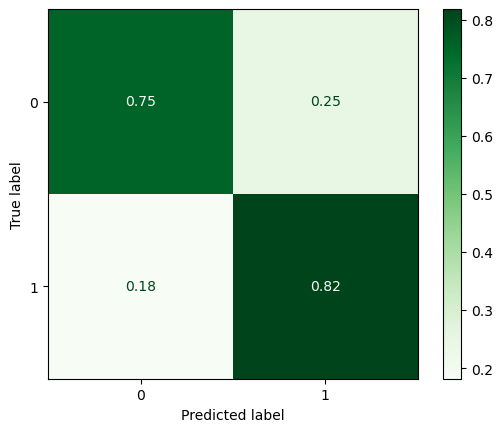

              precision    recall  f1-score   support

           0       0.85      0.75      0.80        61
           1       0.71      0.82      0.76        44

    accuracy                           0.78       105
   macro avg       0.78      0.79      0.78       105
weighted avg       0.79      0.78      0.78       105



In [671]:
# Convert probabilites to class labels with a decision threshold of 0.4
test_preds = convert_probs_to_preds(test_probs,0.43)
# Display a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true',
                                        cmap='Greens')
plt.show()
# Print a classification report
print(classification_report(y_test, test_preds))

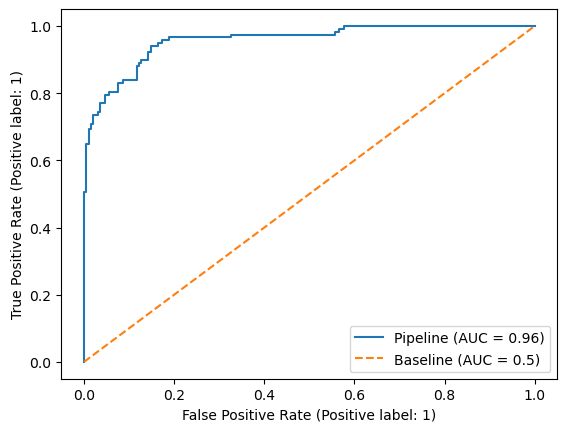

In [672]:
# Visualize the ROC curve > Random Forest tuning
RocCurveDisplay.from_estimator(gs_best, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

##  permutation importance 

In [673]:
preprocessing_Column.fit(X_train)

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [674]:
## fit column transformer and run get_feature_names_out
preprocessing_Column.fit(X_train)
feature_names = preprocessing_Column.get_feature_names_out()

X_train_tf = pd.DataFrame(preprocessing_Column.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_tf = pd.DataFrame(preprocessing_Column.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_tf.head(3)

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age[y],Drug_D-penicillamine,Drug_NA,Drug_Placebo,Sex_M,Ascites_N,Ascites_NA,Ascites_Y,Hepatomegaly_N,Hepatomegaly_NA,Hepatomegaly_Y,Spiders_N,Spiders_NA,Spiders_Y,Edema_N,Edema_S,Edema_Y
321,0.088783,-0.452368,-0.234167,0.437286,-0.247391,-0.297505,-0.149419,-0.18721,-1.235619,-0.214579,-0.010790,1.220659,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
324,2.707224,-0.287371,-0.234167,-0.633503,-0.247391,-0.297505,-0.149419,-0.18721,-0.046003,7.535032,-1.136558,-1.568094,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
388,-0.315646,-0.546652,-0.234167,-1.061818,-0.247391,-0.297505,-0.149419,-0.18721,-0.967827,-0.731220,1.114978,1.499611,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [675]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)


r = permutation_importance(rf, X_train_tf, y_train ,n_repeats =5, random_state =42)
r.keys()


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [676]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_tf.columns,
                           name = 'permutation importance')
perm_importances.head()


N_Days         0.076677
Bilirubin      0.035144
Cholesterol    0.005112
Albumin        0.000639
Copper         0.010863
Name: permutation importance, dtype: float64

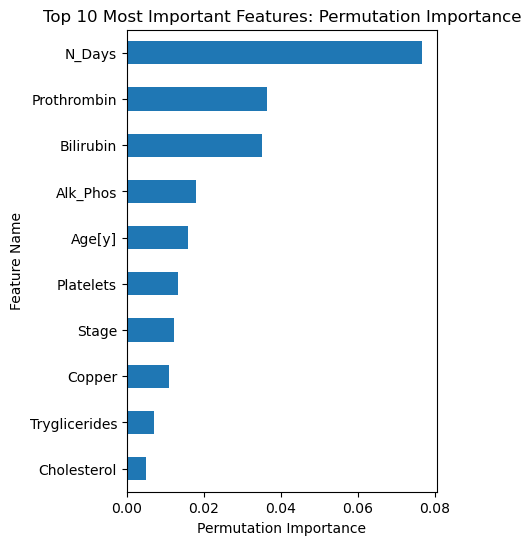

In [683]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');
plt.savefig("perm_importances.png", bbox_inches='tight')

* N_Days:
Represents the number of days between registration and the occurrence of a significant event such as death, liver transplantation, or study analysis.
Reflects the disease progression over time and its severity.
Might play a role in estimating the recovery period or the patient's response to treatment.
* Prothrombin:
Indicates the blood clotting rate and its ability to coagulate.
Changes in prothrombin levels may be indicative of liver damage and impaired function.
* Bilirubin:
Reflects the level of bilirubin in the blood, which is an indicator of the liver's function in removing waste and toxins from the body.
Elevated bilirubin levels may indicate liver damage or bile duct obstruction.
* Alk_Phos (Alkaline Phosphatase):
Indicates alkaline phosphatase levels in the blood, which can increase in conditions such as liver enlargement or gallbladder issues.
It may be an indicator of liver or bile duct disorders.
These four features represent important indicators of liver function and disease progression. They can be highly useful in predicting liver cirrhosis and understanding the factors associated with it.

### Create Explanatory Visualizations for the most important features.


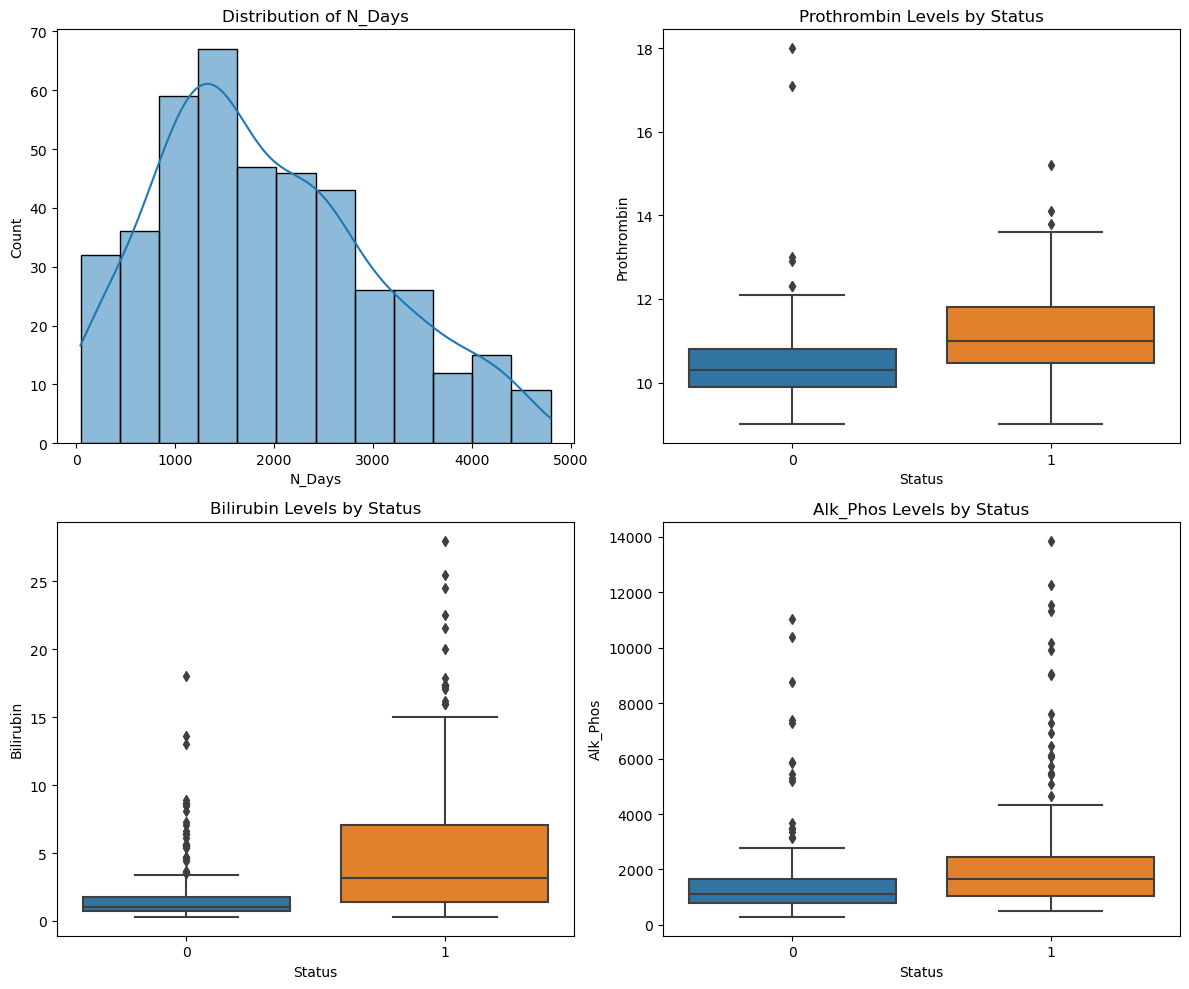

In [693]:
# N_DAYS  
# Create subplots for each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# N_Days histogram
sns.histplot(data=df, x='N_Days', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of N_Days')

# Prothrombin box plot
sns.boxplot(data=df, x='Status', y='Prothrombin', ax=axes[0, 1])
axes[0, 1].set_title('Prothrombin Levels by Status')

# Bilirubin box plot
sns.boxplot(data=df, x='Status', y='Bilirubin', ax=axes[1, 0])
axes[1, 0].set_title('Bilirubin Levels by Status')

# Alk_Phos box plot
sns.boxplot(data=df, x='Status', y='Alk_Phos', ax=axes[1, 1])
axes[1, 1].set_title('Alk_Phos Levels by Status')

plt.tight_layout()
plt.show()
fig.savefig("the_most_important_features.png", bbox_inches='tight')

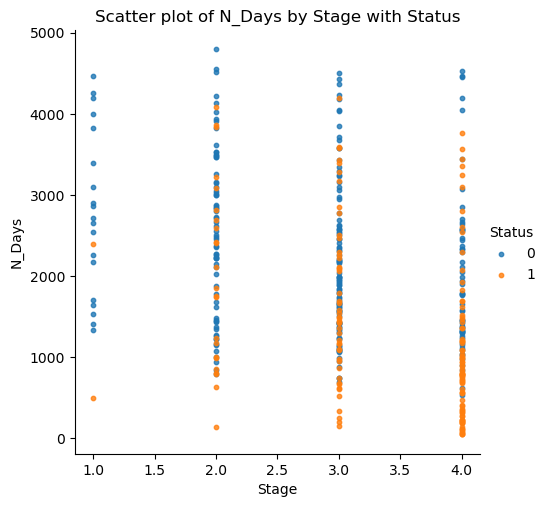

In [688]:
grid = sns.lmplot(data=df, x='Stage', y='N_Days', hue="Status", fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.8, 'linewidth': 1} )
plt.title('Scatter plot of N_Days by Stage with Status')
plt.show()

Text(0.5, 1.0, 'Distribution of N_Days')

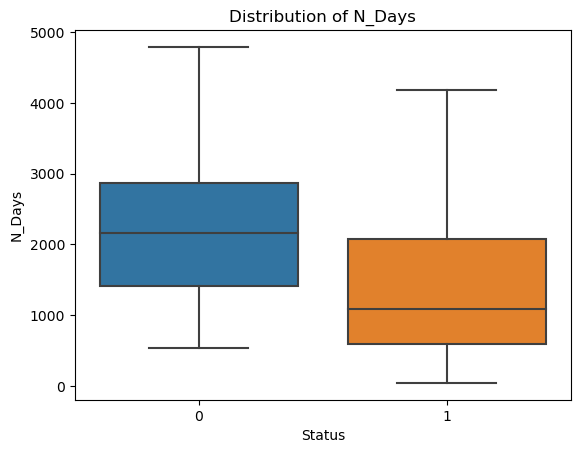

In [691]:
ax=sns.boxplot(data=df, x='Status', y='N_Days',)
ax.set_title('Distribution of N_Days')

I participated in the distribution of the number of days between enrollment and the occurrence of an important event such as the onset or occurrence of a liver transplant.
The graph displays the volume of prothrombin, bilirubin, and alkalinity among groups of people according to their condition (eg, people who died and those who experienced the cirrhosis phase).